# PINN for Poisson equation

$$
\nabla^2 u = f
$$



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from kan import *

# Check device (use MPS if on silicon Mac or CUDA if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# print device
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define the analytical solution
def analytical_solution(x, y):
    return torch.sin(4 * np.pi * (x + y)) + torch.cos(4 * np.pi * x * y)


In [6]:
# Define the model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            KAN(width=[2, 5, 5, 1], grid=5, k=10, grid_eps=1.0, noise_scale=0.25, device=device).speed()
        )

    def forward(self, xy):
        # xy represents the coordinates (x, y) concatenated
        u = self.net(xy)
        return u

def laplacian(u, xy):
    # Compute gradients du/dx and du/dy
    grads = torch.autograd.grad(outputs=u, inputs=xy, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    # Compute second derivatives 
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True, retain_graph=True)[0][:, 1]
    
    laplacian = u_xx + u_yy
    return laplacian 

def loss_pinn(model, xy, x_boundary, u_boundary, f):
    xy = xy.clone().detach().requires_grad_(True)
    x_boundary = x_boundary.clone().detach().requires_grad_(True)
    f = f.clone().detach()
    #predictions
    u = model(xy)
    #compute laplacian
    laplacian_u = laplacian(u, xy)
    physical_loss = torch.mean((laplacian_u - f)**2)
    # boundary condition loss
    u_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((u_boundary_pred - u_boundary)**2)
    return physical_loss +  10 * boundary_loss




In [7]:
# Problem setup
# Interior points (uniformly sampled within [0 , 1] x [0, 1])
x_interior = torch.rand((1000, 2), device=device)  # Random points in [0, 1] x [0, 1]
# f is the source term i.e. laplactian of u
x_interior = x_interior.requires_grad_(True)
u_analytical = analytical_solution(x_interior[:, 0], x_interior[:, 1])
f = laplacian(u_analytical, x_interior)
x_interior.requires_grad_(False) 

# Boundary points
x_boundary_x = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
x_boundary = torch.cat([
    torch.cat([x_boundary_x, torch.zeros_like(x_boundary_x)], dim=1),
    torch.cat([x_boundary_x, torch.ones_like(x_boundary_x)], dim=1),
    torch.cat([torch.zeros_like(x_boundary_x), x_boundary_x], dim=1),
    torch.cat([torch.ones_like(x_boundary_x), x_boundary_x], dim=1),
], dim=0)

# Boundary condition values using the analytical solution
u_boundary = analytical_solution(x_boundary[:, 0], x_boundary[:, 1]).unsqueeze(1).to(device)




In [9]:

# Training
num_epochs_adam = 4000  
num_epochs_lbfgs = 500  
lr_adam = 0.005  
lr_lbfgs = 0.1 

model = PINN().to(device)

optimizer_adam = optim.Adam(model.parameters(), lr=lr_adam)

print("Starting Adam training...")
for epoch in range(num_epochs_adam):
    optimizer_adam.zero_grad()
    loss = loss_pinn(model, x_interior, x_boundary, u_boundary, f)
    loss.backward()
    optimizer_adam.step()

    if epoch % 100 == 0:
        print(f"Adam Epoch {epoch}: Loss = {loss.item()}")

optimizer_lbfgs = optim.LBFGS(
    model.parameters(),
    lr=lr_lbfgs,
    tolerance_grad=1e-4,     
    tolerance_change=1e-9,
)

def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_pinn(model, x_interior, x_boundary, u_boundary, f)
    loss.backward()
    return loss

print("Starting L-BFGS training...")
for epoch in range(num_epochs_lbfgs):
    optimizer_lbfgs.step(closure)

    if epoch % 100 == 0:
        current_loss = closure()
        print(f"L-BFGS Epoch {epoch}: Loss = {current_loss.item()}")

checkpoint directory created: ./model
saving model version 0.0
Starting Adam training...
Adam Epoch 0: Loss = 43302.44140625
Adam Epoch 100: Loss = 10172.8369140625
Adam Epoch 200: Loss = 358.8377685546875
Adam Epoch 300: Loss = 179.873291015625
Adam Epoch 400: Loss = 111.17412567138672
Adam Epoch 500: Loss = 76.1919937133789
Adam Epoch 600: Loss = 54.66202926635742
Adam Epoch 700: Loss = 40.77444839477539
Adam Epoch 800: Loss = 29.95623779296875
Adam Epoch 900: Loss = 22.080781936645508
Adam Epoch 1000: Loss = 18.06277847290039
Adam Epoch 1100: Loss = 15.54155445098877
Adam Epoch 1200: Loss = 25.897605895996094
Adam Epoch 1300: Loss = 28.85113525390625
Adam Epoch 1400: Loss = 11.530107498168945
Adam Epoch 1500: Loss = 12.496978759765625
Adam Epoch 1600: Loss = 10.64475154876709
Adam Epoch 1700: Loss = 9.270291328430176
Adam Epoch 1800: Loss = 8.455161094665527
Adam Epoch 1900: Loss = 8.539827346801758
Adam Epoch 2000: Loss = 12.539511680603027
Adam Epoch 2100: Loss = 24.59297370910644

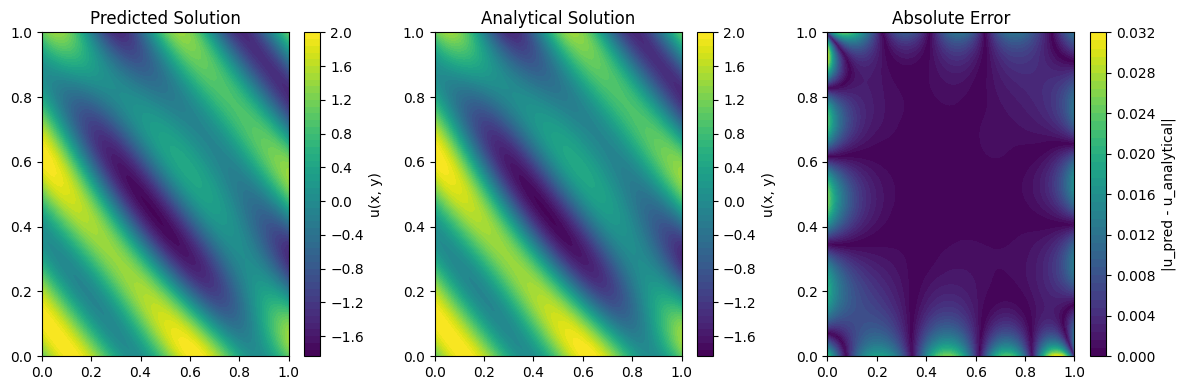

In [13]:
# Plotting: 
grid_x, grid_y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Predict solution on the grid
with torch.no_grad():
    u_pred = model(grid_points).reshape(100, 100).cpu().numpy()

# Calculate analytical solution on the grid
x_vals = grid_x.cpu().numpy()
y_vals = grid_y.cpu().numpy()
u_analytical = analytical_solution(grid_x, grid_y).cpu().numpy()

# Plot the predicted solution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.contourf(x_vals, y_vals, u_pred, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Predicted Solution")

# Plot the analytical solution
plt.subplot(1, 3, 2)
plt.contourf(x_vals, y_vals, u_analytical, levels=50)
plt.colorbar(label="u(x, y)")
plt.title("Analytical Solution")

# Plot the difference
plt.subplot(1, 3, 3)
plt.contourf(x_vals, y_vals, np.abs(u_pred - u_analytical), levels=50)
plt.colorbar(label="|u_pred - u_analytical|")
plt.title("Absolute Error")

plt.tight_layout()
plt.savefig("pinn_KAN.pdf", format="pdf")
plt.show()

In [14]:
# Mean squared error of solution
mse = torch.mean((torch.tensor(u_pred) - torch.tensor(u_analytical))**2)
print(f"Mean Squared Error: {mse:.6f}")


Mean Squared Error: 0.000031
